In [ ]:
# Copyright (c) 2024, Edward Jakunskas, Department of Electronic Engineering, Maynooth University
#
# Maintainer: Edward Jakunskas (edward.jakunskas@mu.ie)
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.
#
# 2. Redistributions in binary form must reproduce the above copyright notice, this
#    list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

In [11]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


sam_checkpoint = base_dir + "/SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device);

In [14]:
base_dir = "/workspace/Data/"


In [4]:
def read_png_with_alpha(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    if image.shape[2] == 4:
        bgr_channels = image[:, :, :3]
        alpha_channel = image[:, :, 3]

        bgr_channels[alpha_channel == 0] = (0, 0, 0)
        
        image_with_black_background = cv2.merge([bgr_channels, alpha_channel])
        print("removed alpha")
        return image_with_black_background
    else:
        print("no alpha")
        return image

In [5]:
def checkcolour(masks, hsv):
    colours = np.zeros((0,3))

    for i in range(len(masks)):
        color = hsv[masks[i]['segmentation']].mean(axis=(0))
        colours = np.append(colours,color[None,:], axis=0)
        
    idx_green = (colours[:,0]<85) & (colours[:,0]>5) & ((colours[:,2]>90) | ( (colours[:,1]>15) & (colours[:,2]>45)))
    
    return(idx_green)

In [100]:
dates = ['visualisation']  # List of dates/folders to process

# SAM mask generator configuration
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64, 
    pred_iou_thresh=0.80,
    stability_score_thresh=0.90,
    crop_n_layers=2,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=100,
)
    
for date in dates:
    #depth_seg_folder - folder of thresholded depth images, input to SAM and input to YOLO
    #results_folder - where results will be saved
    #npz_folder - outputs from SAM
    depth_seg_folder = os.path.join(base_dir, date, date + '_depth_seg/')
    results_folder = os.path.join(base_dir, date, date + '_results/')
    npz_folder = os.path.join(base_dir, date, date + '_npz/')

    #ensure output folders exist
    os.makedirs(results_folder, exist_ok=True)
    os.makedirs(npz_folder, exist_ok=True)

    depth_seg_names = [x for x in os.listdir(depth_seg_folder) if '.jpg' in x]
    depth_seg_paths = [os.path.join(depth_seg_folder, x) for x in depth_seg_names]
    print(depth_seg_paths)

    for imname in depth_seg_names:
        #define the corresponding .npz filename
        npz_file_path = os.path.join(npz_folder, imname.replace('.jpg', '_SAM.npz'))

        #check if the .npz file already exists, skip processing if it does - this takes hours to run so want to be able to handle interruptions
        if os.path.exists(npz_file_path):
            print(f"Skipping {imname}, already processed.")
            continue  # Skip to the next image

        print(f"Processing {imname}")
        image = read_png_with_alpha(os.path.join(depth_seg_folder, imname)) # if depth segmented image is png, SAM ignores alpha channel and draws masks on background also
        if image is None:
            print(f"Error loading image {os.path.join(depth_seg_folder, imname)}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, None, fx=0.5, fy=0.5)  #downsize image to improve speed
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        #get masks, this took approx 100 second son a 4090 in a docker container
        masks = mask_generator.generate(image)

        # kept the checkColour from leaf only sam, edited it to suit oats and our specific better
        idx_green = checkcolour(masks, hsv)

        masks_g = []
        for idx, use in enumerate(idx_green):
            if use:
                masks_g.append(masks[idx])

        # Save results as npz file
        np.savez(npz_file_path, masks_g)
        print(f"Done processing {imname} in {date}")


['/workspace/Data/visualisation/visualisation_depth_seg/masked_D-5-1_rgb_cam19443010D1BE671300_04_09_2024_08_37_48_X795.0_Y1466.2_Z635.0_RX-120.0_RY90.0_RZ0.0_56.jpg', '/workspace/Data/visualisation/visualisation_depth_seg/masked_D-5-1_rgb_cam18443010715BEE0F00_04_09_2024_08_37_44_X519.9_Y1466.2_Z690.1_RX180.0_RY0.0_RZ0.0_49.jpg', '/workspace/Data/visualisation/visualisation_depth_seg/masked_D-5-1_rgb_cam18443010715BEE0F00_04_09_2024_08_32_30_X380.3_Y1466.2_Z690.1_RX180.0_RY0.0_RZ180.0_49.jpg', '/workspace/Data/visualisation/visualisation_depth_seg/masked_D-5-1_rgb_cam19443010D1BE671300_04_09_2024_08_32_34_X105.2_Y1466.2_Z635.0_RX-120.0_RY90.0_RZ180.0_56.jpg']
Skipping masked_D-5-1_rgb_cam19443010D1BE671300_04_09_2024_08_37_48_X795.0_Y1466.2_Z635.0_RX-120.0_RY90.0_RZ0.0_56.jpg, already processed.
Skipping masked_D-5-1_rgb_cam18443010715BEE0F00_04_09_2024_08_37_44_X519.9_Y1466.2_Z690.1_RX180.0_RY0.0_RZ0.0_49.jpg, already processed.
Skipping masked_D-5-1_rgb_cam18443010715BEE0F00_04_09_2

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from ultralytics import YOLO

model = YOLO('/workspace/YOLOv8/runs/detect/train25/weights/best.pt')

#define colors for each class
colors = {
    'Leaf': (255, 0, 0),    # Blue
    'Panicle': (0, 0, 255), # Red
    'Stem': (0, 255, 255),  # Yellow
    'pot': (128, 0, 128),    # Purple
}

#640x640 'fit with border' is what YOLO model was trained on
def resize_and_pad(image):
    h, w = image.shape[:2]
    if h > w:
        new_h = 640
        new_w = int(w * (640 / h))
    else:
        new_w = 640
        new_h = int(h * (640 / w))
    
    resized_image = cv2.resize(image, (new_w, new_h))
    pad_vertical = (640 - new_h) // 2
    pad_horizontal = (640 - new_w) // 2
    
    padded_image = cv2.copyMakeBorder(resized_image, pad_vertical, pad_vertical, pad_horizontal, pad_horizontal, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    
    return padded_image

#process segmentation masks and add labels to the npz data
def add_labels_to_masks(npz_data, original_image):
    original_h, original_w = original_image.shape[:2]
    masks = npz_data['arr_0']
    
    for i, mask in enumerate(masks):
        segmentation_mask = mask['segmentation'].astype(np.uint8)

        resized_segmentation_mask = cv2.resize(segmentation_mask, (original_w, original_h), interpolation=cv2.INTER_NEAREST)
        binary_mask = resized_segmentation_mask > 0
        masked_image = cv2.bitwise_and(original_image, original_image, mask=resized_segmentation_mask)

        contours, _ = cv2.findContours(resized_segmentation_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        #feed each mask into YOLO as a bounding box (while removing background of the mask)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            
            cropped_image = masked_image[y:y+h, x:x+w]
            resized_padded_image = resize_and_pad(cropped_image)

            prediction = model.predict(resized_padded_image, verbose=False)
            #print("YOLO Predictions: ")
            # for predict in prediction:
            #     predict.show()  # Display to screen
            
            if prediction[0].boxes:
                label = prediction[0].names[int(prediction[0].boxes.cls[0].item())]
            else:
                label = 'No Detection'  #default label for no detection
            
            mask['label'] = label
    
    return masks

def process_images(image_paths, results_folder_name):
    for image_path in image_paths:
        npz_path = os.path.splitext(image_path)[0] + '_SAM.npz' #replace file extension with _SAM.npz
        npz_path = npz_path.replace('depth_seg', 'npz') #replace folder name
        npz_data = np.load(npz_path, allow_pickle=True)
        depth_raw_path = image_path.replace('masked_', 'depth_').replace('depth_seg', 'depth_raw') #depth anything labeling incosistency check + change folder name

        check_img = depth_raw_path.replace('_depth_raw', results_folder_name)

        if os.path.exists(check_img):
            print(f"Skipping {check_img}, already processed.")
            continue  # again this takes a while to run so this is a way of saving progress.
        # load the original image
        original_image = cv2.imread(image_path)

        # accounting for png or jpg here
        if original_image.shape[2] == 4:
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGRA2BGR)
        else:
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
         
        masks = add_labels_to_masks(npz_data, original_image)
        
        visualize_masks_with_classes(original_image, masks, depth_raw_path)

        #Isolate top leaf from Depth Anything 
        process_leaf_masks_on_depth(original_image, depth_raw_path, results_folder_name, masks)
        

def visualize_masks(original_image, masks, depth_raw_path):
    # create a blank canvas with the same dimensions as the original image
    overlay = np.zeros_like(original_image, dtype=np.uint8)
    original_h, original_w = original_image.shape[:2]
    # overlay the masks on the canvas
    for mask in masks:
        segmentation_mask = mask['segmentation'].astype(np.uint8)
        resized_segmentation_mask = cv2.resize(segmentation_mask, (original_w, original_h), interpolation=cv2.INTER_NEAREST)
        label = mask.get('label', 'No Label')
        
        # Get color corresponding to the label
        color = colors.get(label, (255, 255, 255))  # default to white if unknown
        
        contours, _ = cv2.findContours(resized_segmentation_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, color, thickness=2)
        
        overlay[resized_segmentation_mask > 0] = (overlay[resized_segmentation_mask > 0] * 0.5 + np.array(color) * 0.5).astype(np.uint8)
    
    #overlay
    output_image = cv2.addWeighted(original_image, 0.5, overlay, 0.5, 0)
    output_image_bgr = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR) #for cv2 imwrite need bgr, this was a bug in original code
    write_folder = depth_raw_path.replace('_depth_raw', '_yolo_overlay')
    
    cv2.imwrite(write_folder, output_image_bgr)
    # Display the result
    plt.figure(figsize=(10, 5))
    plt.imshow(output_image)
    plt.title(f'Overlayed Masks with YOLOv8 Labels')
    plt.axis('off')
    plt.show()

def visualize_class_masks(original_image, masks, class_label): #was used for debugging, could get to work again for visualisation
    blank_image = np.zeros_like(original_image, dtype=np.uint8)
    original_h, original_w = original_image.shape[:2]
    
    combined_mask = np.zeros((original_h, original_w), dtype=np.uint8)
    # Count the number of masks for the specific label - lots of overlap so this not actually useful for counting panicles yet
    label_count = 0
    for mask in masks:
        if mask.get('label', 'No Label') == class_label:
            segmentation_mask = mask['segmentation'].astype(np.uint8)
            resized_segmentation_mask = cv2.resize(segmentation_mask, (original_w, original_h), interpolation=cv2.INTER_NEAREST)
            combined_mask = np.maximum(combined_mask, resized_segmentation_mask)
            label_count += 1

    # Create a binary mask where the class mask areas are preserved, and the rest of the image is black
    masked_image = cv2.bitwise_and(original_image, original_image, mask=combined_mask)

def visualize_masks_with_classes(original_image, masks, depth_raw_path):
    # Display the combined overlay with all masks and labels
    visualize_masks(original_image, masks, depth_raw_path)
    
    # debug: visualize each class-specific mask overlay

    # visualize_class_masks(original_image, masks, 'Panicle')
    # visualize_class_masks(original_image, masks, 'Stem')
    # visualize_class_masks(original_image, masks, 'Leaf')

def process_leaf_masks_on_depth(original_rgb_image, depth_raw_path, results_folder_name, masks):
    depth_image = cv2.imread( depth_raw_path, cv2.IMREAD_GRAYSCALE)
    depth_image_resized = cv2.resize(depth_image, (original_rgb_image.shape[1], original_rgb_image.shape[0]))
    
    leaf_intensity_data = []  # store leaf mask and average intensity
    
    for i, mask in enumerate(masks):
        if mask.get('label') == 'Leaf':
            segmentation_mask = mask['segmentation'].astype(np.uint8)
            resized_segmentation_mask = cv2.resize(segmentation_mask, (depth_image_resized.shape[1], depth_image_resized.shape[0]), interpolation=cv2.INTER_NEAREST)
            
            masked_depth_image = cv2.bitwise_and(depth_image_resized, depth_image_resized, mask=resized_segmentation_mask)
            
            avg_intensity = cv2.mean(masked_depth_image, mask=resized_segmentation_mask)[0] #
            leaf_intensity_data.append((i, avg_intensity))
            
    num_leaves = 1
    #sort by the highest intensity and select the top n, top 1 in this case
    leaf_intensity_data = sorted(leaf_intensity_data, key=lambda x: x[1], reverse=True)[:num_leaves]
    
    # Cut out the top n leaves from the original RGB image
    for i, (mask_index, avg_intensity) in enumerate(leaf_intensity_data):
        mask = masks[mask_index]
        segmentation_mask = mask['segmentation'].astype(np.uint8)
        resized_segmentation_mask = cv2.resize(segmentation_mask, (original_rgb_image.shape[1], original_rgb_image.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        # Mask the original RGB image
        masked_rgb_image = cv2.bitwise_and(original_rgb_image, original_rgb_image, mask=resized_segmentation_mask)
        masked_bgr_image = cv2.cvtColor(masked_rgb_image, cv2.COLOR_RGB2BGR) #for cv2 imwrite need bgr
        write_folder = depth_raw_path.replace('_depth_raw', results_folder_name)
        cv2.imwrite(write_folder , masked_bgr_image)
        
        print(f"wrote to {write_folder} ")


['/workspace/Data/visualisation/visualisation_depth_seg/masked_D-5-1_rgb_cam19443010D1BE671300_04_09_2024_08_37_48_X795.0_Y1466.2_Z635.0_RX-120.0_RY90.0_RZ0.0_56.jpg', '/workspace/Data/visualisation/visualisation_depth_seg/masked_D-5-1_rgb_cam18443010715BEE0F00_04_09_2024_08_37_44_X519.9_Y1466.2_Z690.1_RX180.0_RY0.0_RZ0.0_49.jpg', '/workspace/Data/visualisation/visualisation_depth_seg/masked_D-5-1_rgb_cam18443010715BEE0F00_04_09_2024_08_32_30_X380.3_Y1466.2_Z690.1_RX180.0_RY0.0_RZ180.0_49.jpg', '/workspace/Data/visualisation/visualisation_depth_seg/masked_D-5-1_rgb_cam19443010D1BE671300_04_09_2024_08_32_34_X105.2_Y1466.2_Z635.0_RX-120.0_RY90.0_RZ180.0_56.jpg']


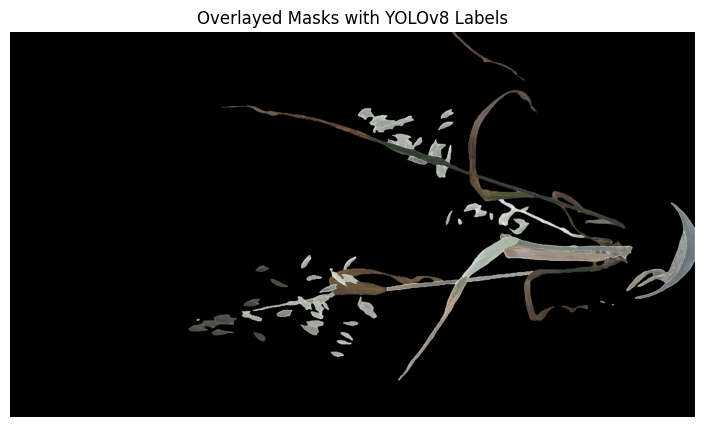

wrote to /workspace/Data/visualisation/visualisation_results_rgb/images/depth_D-5-1_rgb_cam19443010D1BE671300_04_09_2024_08_37_48_X795.0_Y1466.2_Z635.0_RX-120.0_RY90.0_RZ0.0_56.jpg


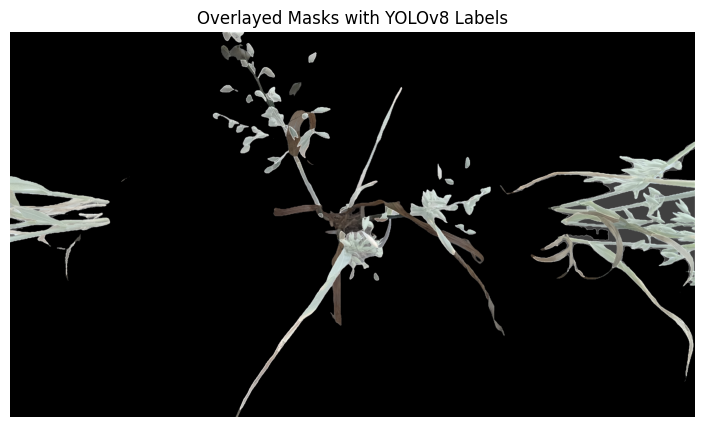

wrote to /workspace/Data/visualisation/visualisation_results_rgb/images/depth_D-5-1_rgb_cam18443010715BEE0F00_04_09_2024_08_37_44_X519.9_Y1466.2_Z690.1_RX180.0_RY0.0_RZ0.0_49.jpg


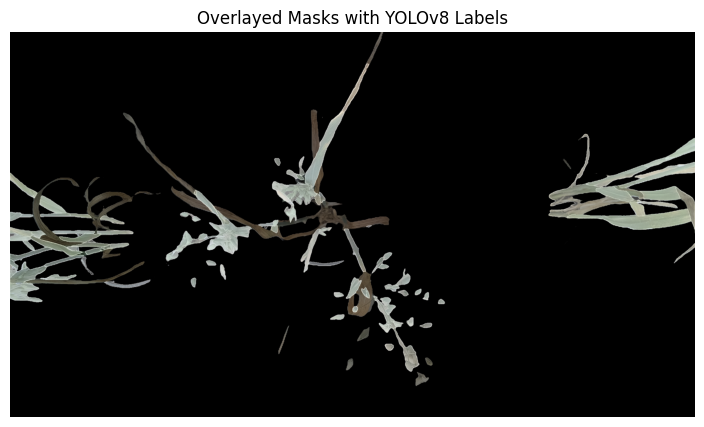

wrote to /workspace/Data/visualisation/visualisation_results_rgb/images/depth_D-5-1_rgb_cam18443010715BEE0F00_04_09_2024_08_32_30_X380.3_Y1466.2_Z690.1_RX180.0_RY0.0_RZ180.0_49.jpg


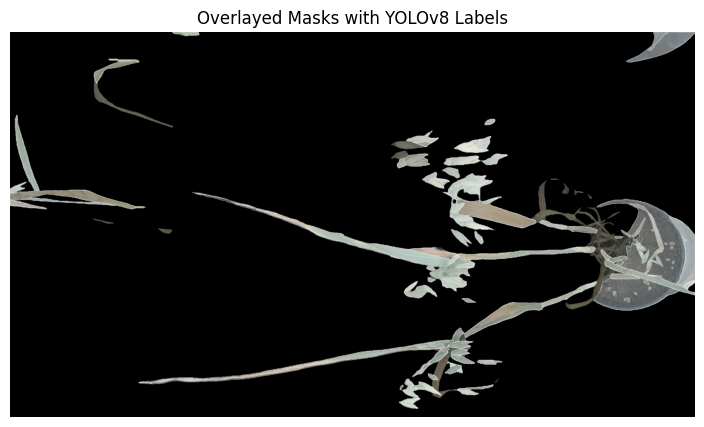

wrote to /workspace/Data/visualisation/visualisation_results_rgb/images/depth_D-5-1_rgb_cam19443010D1BE671300_04_09_2024_08_32_34_X105.2_Y1466.2_Z635.0_RX-120.0_RY90.0_RZ180.0_56.jpg


In [99]:
base_dir = '/workspace/Data'
dates = ['visualisation']  # List of dates to process

for date in dates:
    #depth_seg_folder - folder of thresholded depth images, input to SAM and input to YOLO
    #results_folder - where results will be saved
    #npz_folder - outputs from SAM
    depth_seg_folder = os.path.join(base_dir, date, date + '_depth_seg/')
    results_folder_name = '_results_rgb/images'
    results_folder = os.path.join(base_dir, date, date + results_folder_name)
    
    npz_folder = os.path.join(base_dir, date, date + '_npz/')

    os.makedirs(results_folder, exist_ok=True)
    os.makedirs(npz_folder, exist_ok=True)

    #get list of image files for each date
    depth_seg_names = [x for x in os.listdir(depth_seg_folder) if x.endswith(('.jpg', '.png'))]
    depth_seg_paths = [os.path.join(depth_seg_folder, x) for x in depth_seg_names]
    print(depth_seg_paths)
    process_images(depth_seg_paths, results_folder_name)